In [8]:
import pandas as pd
patients = pd.read_csv("Data/trainData/patients.csv")
conditions = pd.read_csv("Data/trainData/conditions.csv")


merged = pd.merge(conditions, patients, left_on="Patient_id", right_on="Id")
merged.drop(["Patient_id"], inplace=True, axis=1)

In [9]:
lung = merged[merged["Diagnosis"] == "Suspected lung cancer (situation)"]

In [10]:
from datetime import datetime, timedelta
import pandas as pd

# Assuming you have already imported your DataFrame as 'merged'

# Convert "Start" column to datetime format
lung["Start"] = pd.to_datetime(lung["Start"], format="%d/%m/%Y")

# Calculate the date 5 years ago
five_years_ago = datetime.now() - timedelta(days=5*365)

# Drop rows where "Start" date is less than 5 years ago
lung = lung[lung["Start"] < five_years_ago]

C:\Users\opuusalu\AppData\Local\Temp\ipykernel_17636\3331434310.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lung["Start"] = pd.to_datetime(lung["Start"], format="%d/%m/%Y")


In [11]:
from datetime import datetime, timedelta
import pandas as pd

# Assuming you have already imported your DataFrame as 'merged'

# Convert "Start" and "DeathDate" columns to datetime format
lung["Start"] = pd.to_datetime(lung["Start"], format="%d/%m/%Y")
lung["DeathDate"] = pd.to_datetime(lung["DeathDate"], format="%d/%m/%Y", errors='coerce')

# Calculate today's date
today = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)

# Set missing "DeathDate" values to today
lung.loc[lung["DeathDate"].isna(), "DeathDate"] = today


In [12]:
from datetime import datetime, timedelta
import pandas as pd

# Assuming you have already imported your DataFrame as 'merged'

# Convert "Start" and "DeathDate" columns to datetime format
lung["Start"] = pd.to_datetime(lung["Start"], format="%d/%m/%Y")
lung["DeathDate"] = pd.to_datetime(lung["DeathDate"], format="%d/%m/%Y", errors='coerce')

# Calculate the date difference
lung["date_difference"] = lung["DeathDate"] - lung["Start"]

# Set missing "DeathDate" values to today
today = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
lung.loc[merged["DeathDate"].isna(), "DeathDate"] = today

# Create a new column "y" based on the condition
lung["y"] = (lung["date_difference"] > timedelta(days=1825)).astype(int)


In [13]:
lung['y'].value_counts()

y
0    458
1    132
Name: count, dtype: int64

In [15]:
# Assuming your DataFrame is named 'merged'
columns_to_drop = ["date_difference", "BirthDate", "DeathDate"]

# Drop the specified columns
lung.drop(columns=columns_to_drop, inplace=True, errors='ignore')

In [17]:
encoded = pd.get_dummies(conditions, columns=["Diagnosis"])


columns = encoded.columns[4:]
#for i in range(4, encoded.columns.count):
 #   print(encoded.columns[i])
aggregated = encoded.groupby("Patient_id").agg({**{col: 'max' for col in columns}})

In [30]:
merged = pd.merge(aggregated, lung[["Id", "y", "Gender"]], left_on="Patient_id", right_on="Id")
merged["Gender"] = merged["Gender"] == "F"

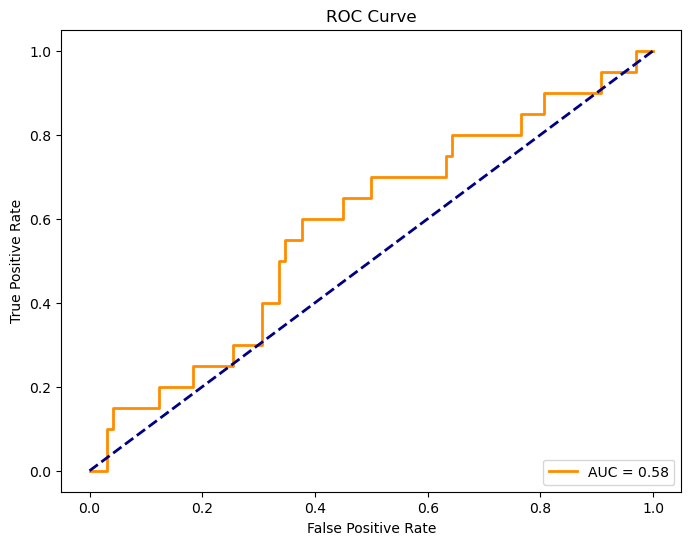

AUC: 0.58


In [51]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Assuming your DataFrame is named 'merged'

# Drop unnecessary columns
X = merged.drop(columns=["y", "Id"])
y = merged["y"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the Random Forest Classifier with some hyperparameter tuning
classifier = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

# Train the classifier
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred_proba = classifier.predict_proba(X_test)[:, 1]  # Probability of class 1

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

print(f'AUC: {roc_auc:.2f}')

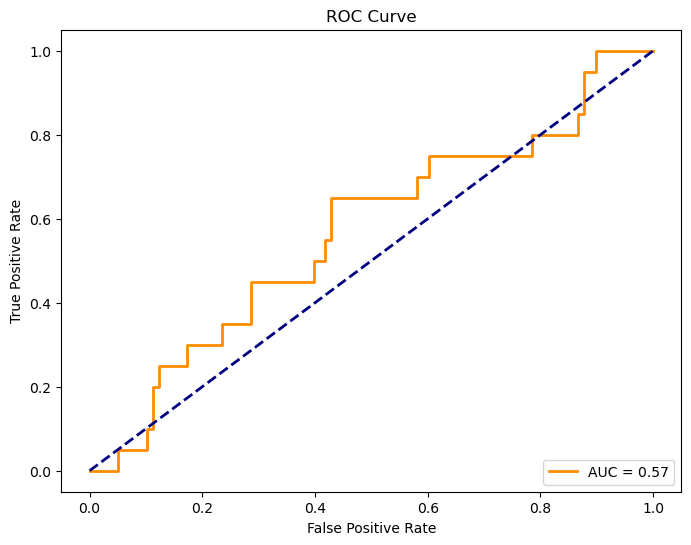

AUC: 0.57


In [49]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'merged'

# Drop unnecessary columns
X = merged.drop(columns=["y", "Id"])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, merged["y"], test_size=0.2, random_state=42)

# Train a model (e.g., Logistic Regression)
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of class 1

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

print(f'AUC: {roc_auc:.2f}')

In [50]:
import numpy as np

# Assuming y_pred is your NumPy array
unique_values, counts = np.unique(y_pred, return_counts=True)

# Create a dictionary to display the counts
counts_dict = dict(zip(unique_values, counts))

print("Predicted Value Counts:")
print(counts_dict)

Predicted Value Counts:
{0: 115, 1: 3}
